In [23]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional,GRU
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt

In [24]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [25]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [26]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [27]:
ticker='TSLA'

In [28]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [29]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [30]:
dates = pd.to_datetime(df['Date'])

In [31]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [32]:
df_for_training = df[cols].astype(float)

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [34]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [35]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [36]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [37]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [38]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [39]:
def build_model(hp):
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model=Sequential()
    model.add(Bidirectional(GRU(hp_units,activation='relu',input_shape=(X.shape[1],X.shape[2]),return_sequences=False)))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [40]:
tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='bi_gru_tuning',
                     )

Reloading Tuner from ./bi_gru_tuning/tuner0.json


In [41]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[early_stop])

In [42]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 144.



In [43]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def forecast_bias(y_true, y_pred):
    return 100 * (np.mean(y_pred) - np.mean(y_true)) / np.mean(y_true)

Epoch 1/1000
3/3 [==============================] - 1s 92ms/step - loss: 0.2093 - val_loss: 0.3258
Epoch 2/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1831 - val_loss: 0.2921
Epoch 3/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1590 - val_loss: 0.2605
Epoch 4/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.1369 - val_loss: 0.2312
Epoch 5/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1167 - val_loss: 0.2043
Epoch 6/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0985 - val_loss: 0.1797
Epoch 7/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0822 - val_loss: 0.1573
Epoch 8/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0678 - val_loss: 0.1370
Epoch 9/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.0552 - val_loss: 0.1187
Epoch 10/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0443 - val_loss: 0.1023
Epoch 11/

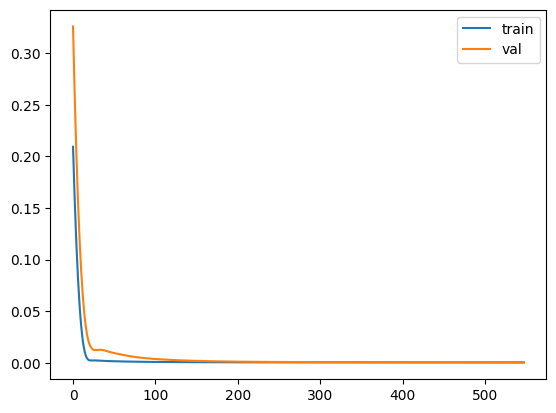

4/4 [==============================] - 0s 4ms/step
train mae: 0.6416750074479094
val mae: 0.3320224365380861
train smape: 4.0619742626274995
val smape: 1.9020020087732685
train forecast bias: -1.2570904634596303
val forecast bias: 1.1537098274861914


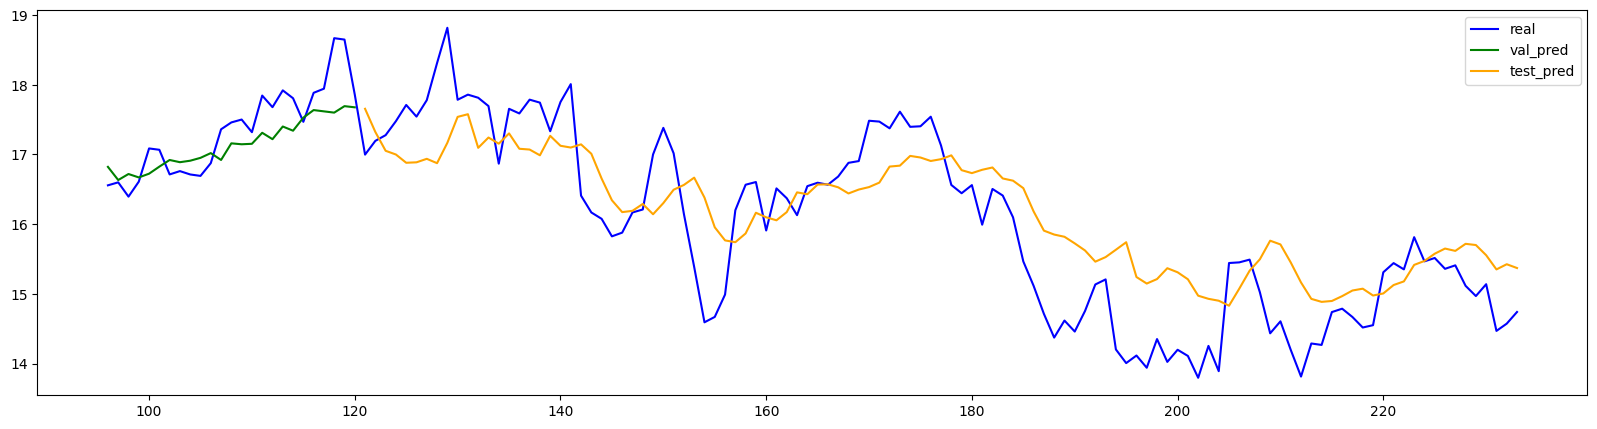

Epoch 1/1000
6/6 [==============================] - 2s 65ms/step - loss: 0.0984 - val_loss: 0.0403
Epoch 2/1000
6/6 [==============================] - 0s 38ms/step - loss: 0.0651 - val_loss: 0.0214
Epoch 3/1000
6/6 [==============================] - 0s 44ms/step - loss: 0.0404 - val_loss: 0.0092
Epoch 4/1000
6/6 [==============================] - 0s 37ms/step - loss: 0.0233 - val_loss: 0.0026
Epoch 5/1000
6/6 [==============================] - 0s 42ms/step - loss: 0.0127 - val_loss: 6.5119e-04
Epoch 6/1000
6/6 [==============================] - 0s 37ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 7/1000
6/6 [==============================] - 0s 34ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 8/1000
6/6 [==============================] - 0s 34ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 9/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 10/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.0048 - val_loss: 0.0072
Epoch

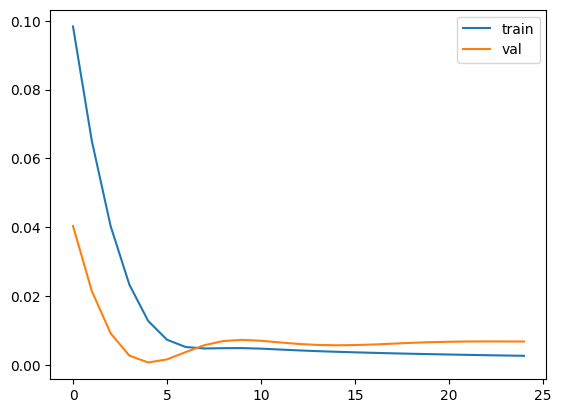

4/4 [==============================] - 0s 5ms/step
train mae: 1.8087857987125362
val mae: 1.5032768562492207
train smape: 12.668494231669639
val smape: 9.774779998611116
train forecast bias: -8.141187990700352
val forecast bias: -9.275641561504319


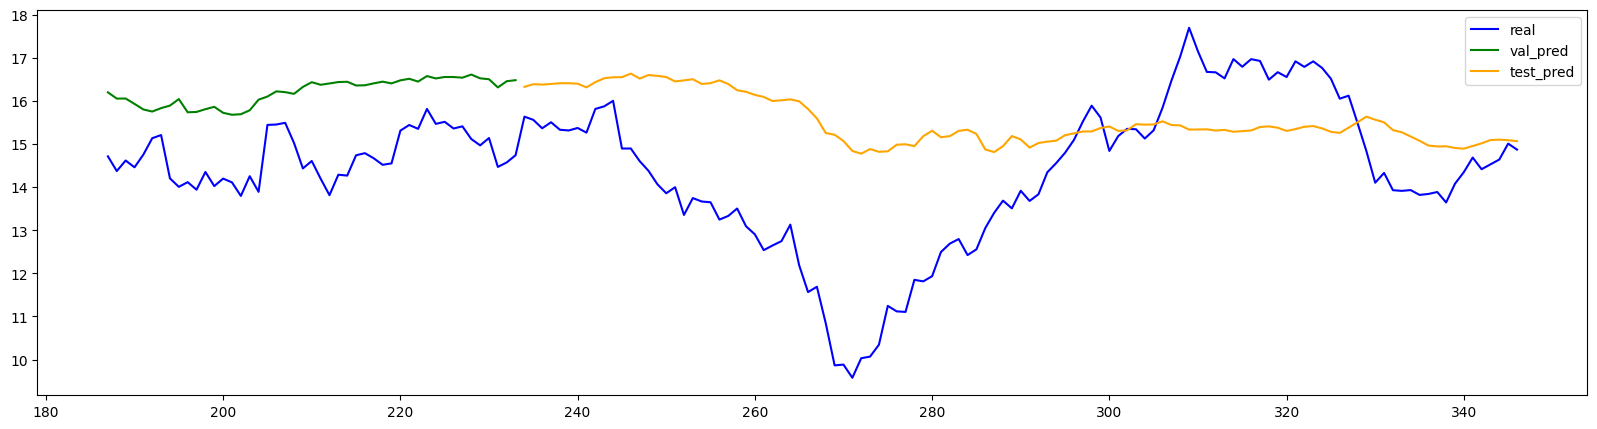

Epoch 1/1000
9/9 [==============================] - 1s 49ms/step - loss: 0.0940 - val_loss: 0.0810
Epoch 2/1000
9/9 [==============================] - 0s 35ms/step - loss: 0.0516 - val_loss: 0.0451
Epoch 3/1000
9/9 [==============================] - 0s 34ms/step - loss: 0.0250 - val_loss: 0.0223
Epoch 4/1000
9/9 [==============================] - 0s 35ms/step - loss: 0.0113 - val_loss: 0.0103
Epoch 5/1000
9/9 [==============================] - 0s 37ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 6/1000
9/9 [==============================] - 0s 34ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 7/1000
9/9 [==============================] - 0s 37ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 8/1000
9/9 [==============================] - 0s 32ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 9/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 10/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 11/

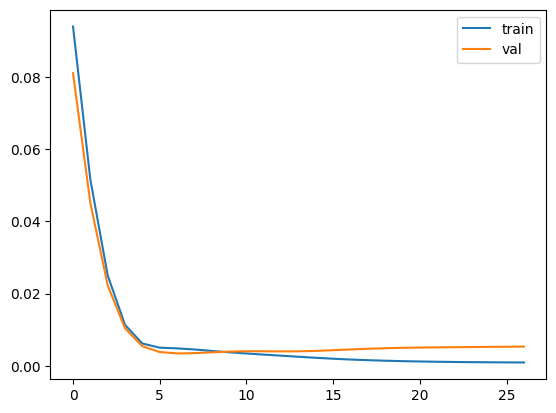

4/4 [==============================] - 0s 4ms/step
train mae: 0.8893941967687017
val mae: 1.227268324744524
train smape: 6.397685426066414
val smape: 8.490549564289223
train forecast bias: 6.226166750251718
val forecast bias: 8.414229656298316


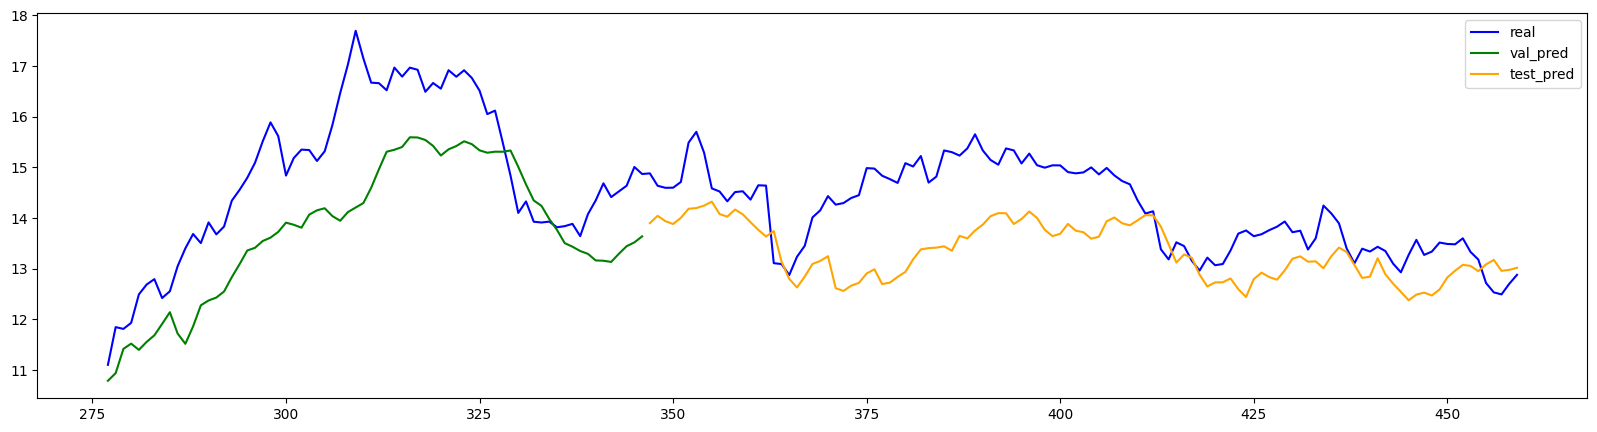

Epoch 1/1000
12/12 [==============================] - 2s 45ms/step - loss: 0.0675 - val_loss: 0.0157
Epoch 2/1000
12/12 [==============================] - 0s 34ms/step - loss: 0.0278 - val_loss: 0.0032
Epoch 3/1000
12/12 [==============================] - 0s 36ms/step - loss: 0.0105 - val_loss: 0.0029
Epoch 4/1000
12/12 [==============================] - 0s 38ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 5/1000
12/12 [==============================] - 0s 34ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 6/1000
12/12 [==============================] - 0s 35ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 7/1000
12/12 [==============================] - 0s 36ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 8/1000
12/12 [==============================] - 0s 35ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 9/1000
12/12 [==============================] - 0s 34ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 10/1000
12/12 [==============================] - 0s 35ms/step - loss: 0.0035 - val_lo

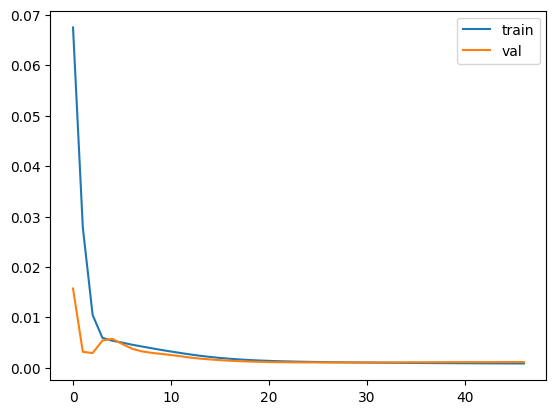

4/4 [==============================] - 0s 5ms/step
train mae: 1.537259698904392
val mae: 0.5161395401292883
train smape: 9.523036870767235
val smape: 3.6681668639644713
train forecast bias: 10.263522125040225
val forecast bias: 1.8134573881352467


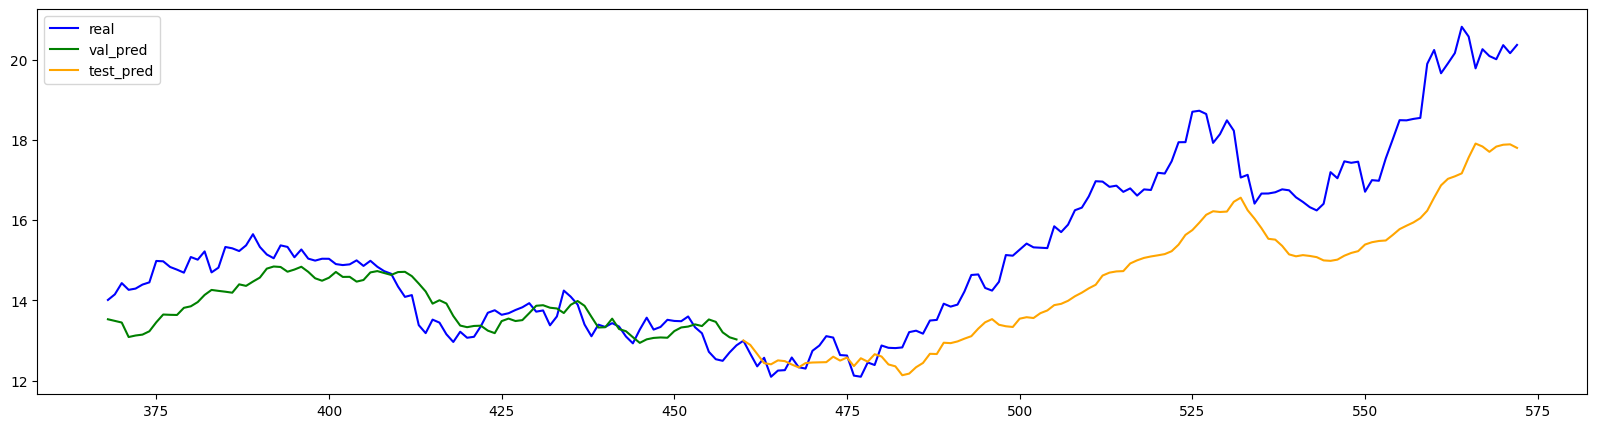

Epoch 1/1000
15/15 [==============================] - 2s 41ms/step - loss: 0.0875 - val_loss: 0.1148
Epoch 2/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0280 - val_loss: 0.0349
Epoch 3/1000
15/15 [==============================] - 1s 34ms/step - loss: 0.0071 - val_loss: 0.0115
Epoch 4/1000
15/15 [==============================] - 1s 34ms/step - loss: 0.0039 - val_loss: 0.0080
Epoch 5/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0037 - val_loss: 0.0081
Epoch 6/1000
15/15 [==============================] - 1s 34ms/step - loss: 0.0034 - val_loss: 0.0089
Epoch 7/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 8/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0030 - val_loss: 0.0087
Epoch 9/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0027 - val_loss: 0.0084
Epoch 10/1000
15/15 [==============================] - 0s 33ms/step - loss: 0.0025 - val_lo

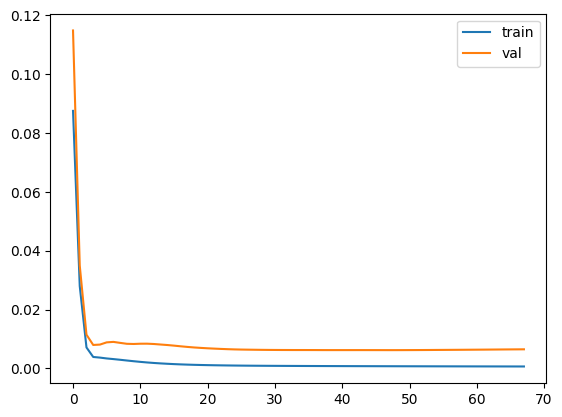

4/4 [==============================] - 0s 4ms/step
train mae: 2.8408836115960314
val mae: 1.4015328119538684
train smape: 13.20259252074896
val smape: 8.888723642903026
train forecast bias: 14.205821048816611
val forecast bias: 9.605154581374556


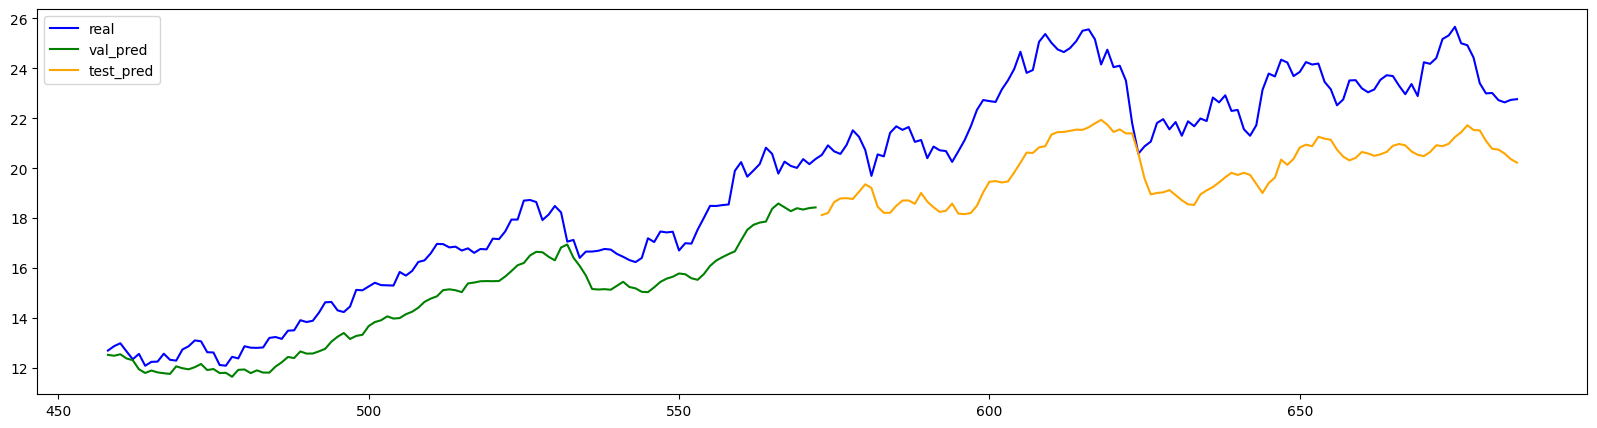

Epoch 1/1000
18/18 [==============================] - 2s 41ms/step - loss: 0.0842 - val_loss: 0.2334
Epoch 2/1000
18/18 [==============================] - 1s 38ms/step - loss: 0.0275 - val_loss: 0.0952
Epoch 3/1000
18/18 [==============================] - 1s 33ms/step - loss: 0.0117 - val_loss: 0.0527
Epoch 4/1000
18/18 [==============================] - 1s 33ms/step - loss: 0.0082 - val_loss: 0.0503
Epoch 5/1000
18/18 [==============================] - 1s 36ms/step - loss: 0.0067 - val_loss: 0.0551
Epoch 6/1000
18/18 [==============================] - 1s 37ms/step - loss: 0.0059 - val_loss: 0.0556
Epoch 7/1000
18/18 [==============================] - 1s 36ms/step - loss: 0.0052 - val_loss: 0.0530
Epoch 8/1000
18/18 [==============================] - 1s 34ms/step - loss: 0.0047 - val_loss: 0.0500
Epoch 9/1000
18/18 [==============================] - 1s 34ms/step - loss: 0.0042 - val_loss: 0.0470
Epoch 10/1000
18/18 [==============================] - 1s 34ms/step - loss: 0.0039 - val_lo

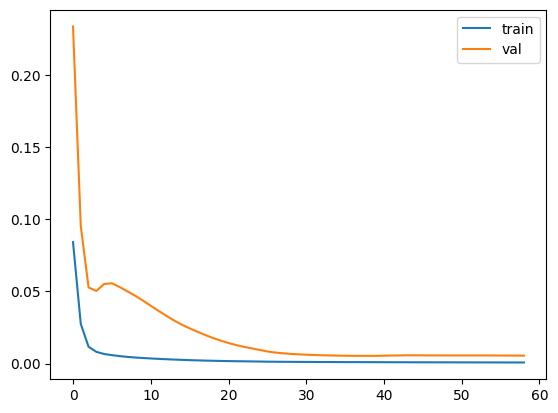

4/4 [==============================] - 0s 3ms/step
train mae: 0.6784325409475681
val mae: 1.174324460843736
train smape: 3.0662219355024045
val smape: 5.28362609788107
train forecast bias: 1.4368718622339125
val forecast bias: 5.060833167151002


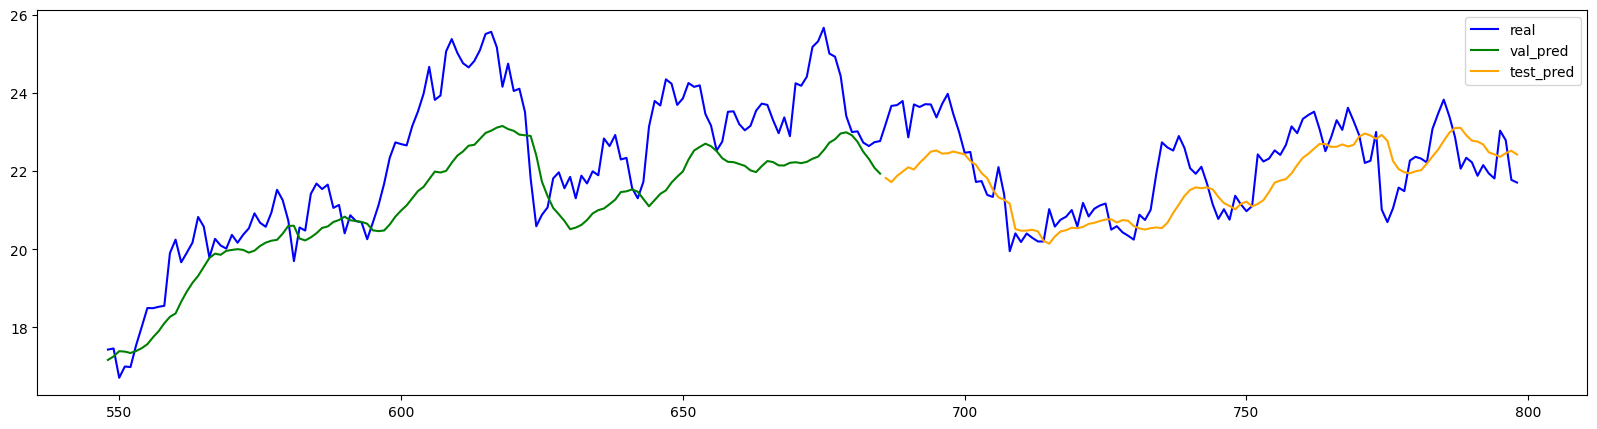

Epoch 1/1000
20/20 [==============================] - 2s 39ms/step - loss: 0.0691 - val_loss: 0.1686
Epoch 2/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0135 - val_loss: 0.0557
Epoch 3/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0116 - val_loss: 0.0336
Epoch 4/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0103 - val_loss: 0.0296
Epoch 5/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0078 - val_loss: 0.0228
Epoch 6/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0060 - val_loss: 0.0156
Epoch 7/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0047 - val_loss: 0.0104
Epoch 8/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 0.0070
Epoch 9/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 10/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0025 - val_lo

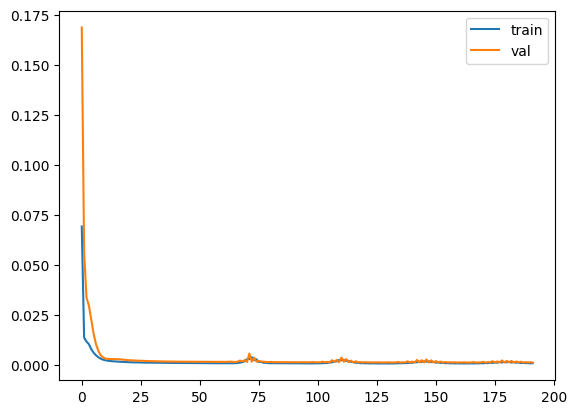

4/4 [==============================] - 0s 4ms/step
train mae: 1.082365167461024
val mae: 0.5040387804519653
train smape: 5.184085966230759
val smape: 2.2423757271497347
train forecast bias: -3.88023977041607
val forecast bias: -0.6827242544640026


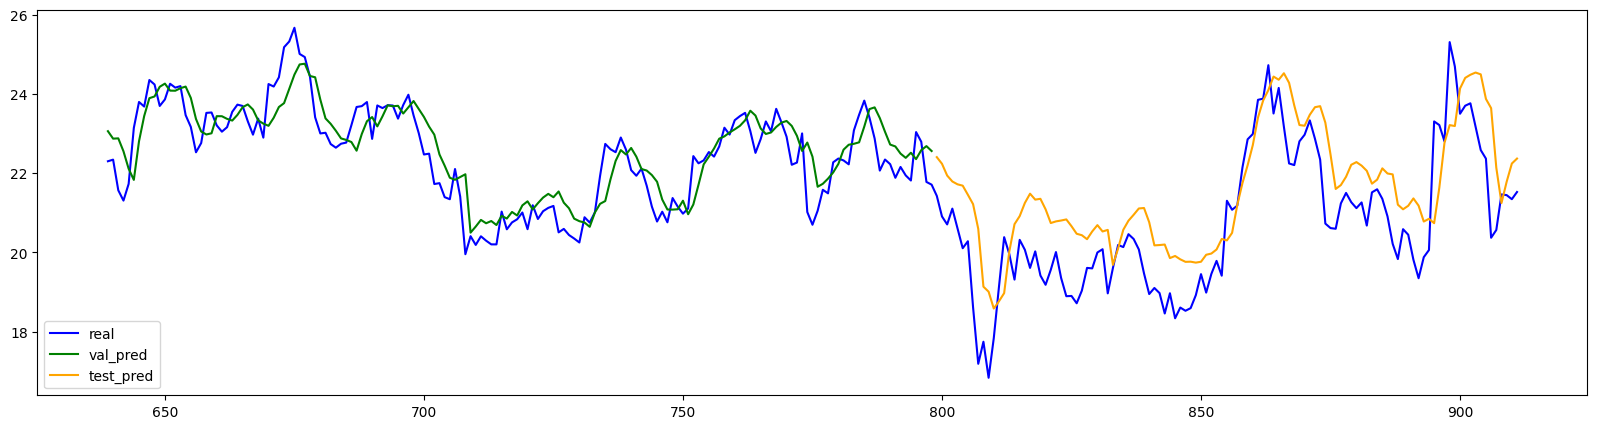

Epoch 1/1000
23/23 [==============================] - 2s 38ms/step - loss: 0.0393 - val_loss: 0.0563
Epoch 2/1000
23/23 [==============================] - 1s 33ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 3/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0116 - val_loss: 0.0091
Epoch 4/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 5/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 6/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 7/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0019 - val_loss: 0.0060
Epoch 8/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.0016 - val_loss: 0.0067
Epoch 9/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 10/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0015 - val_lo

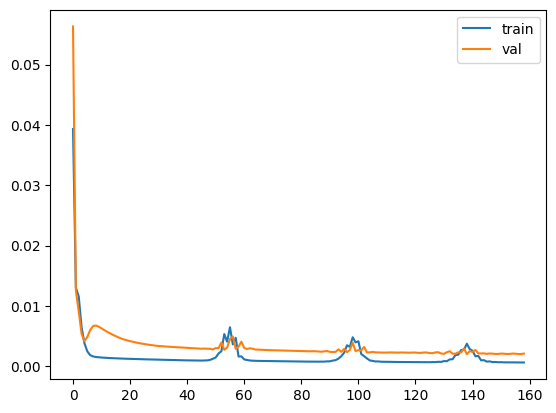

4/4 [==============================] - 0s 6ms/step
train mae: 0.8749804324756724
val mae: 0.6403485474039714
train smape: 4.204593181715032
val smape: 3.0301372072871877
train forecast bias: 1.8943535158003273
val forecast bias: 1.0919949149242538


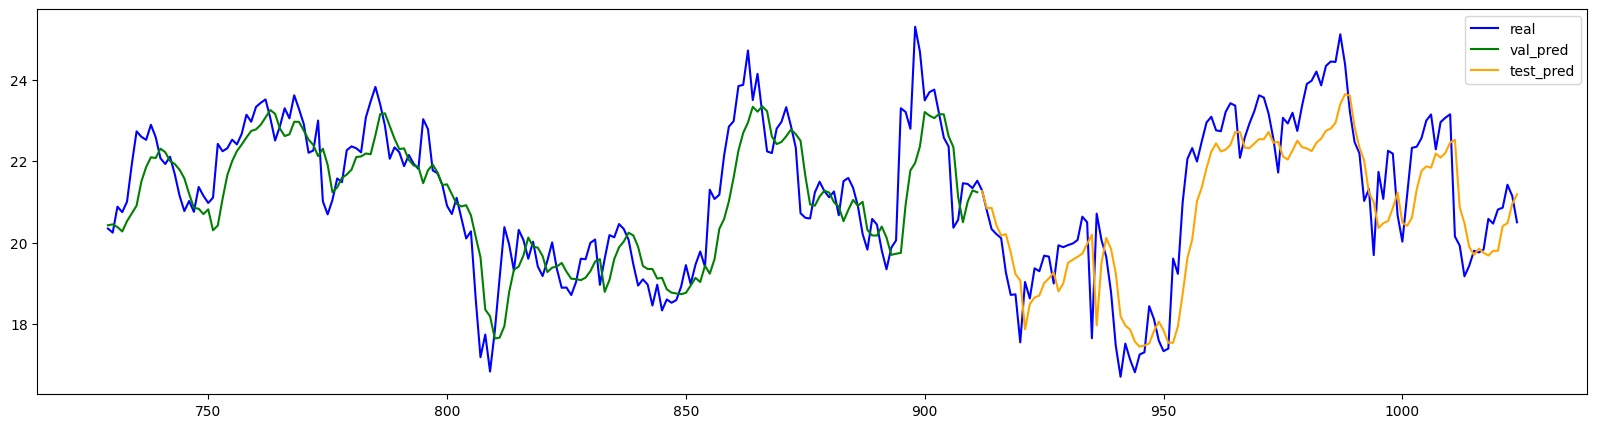

Epoch 1/1000
26/26 [==============================] - 2s 37ms/step - loss: 0.0214 - val_loss: 0.0070
Epoch 2/1000
26/26 [==============================] - 1s 36ms/step - loss: 0.0127 - val_loss: 0.0085
Epoch 3/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0076 - val_loss: 0.0082
Epoch 4/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 5/1000
26/26 [==============================] - 1s 34ms/step - loss: 0.0038 - val_loss: 0.0088
Epoch 6/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0032 - val_loss: 0.0072
Epoch 7/1000
26/26 [==============================] - 1s 32ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 8/1000
26/26 [==============================] - 1s 32ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 9/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 10/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0020 - val_lo

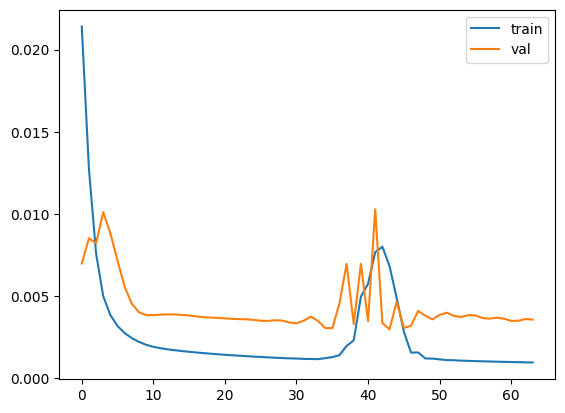

4/4 [==============================] - 0s 6ms/step
train mae: 0.5625232914806805
val mae: 0.9130323761968847
train smape: 3.42959397415502
val smape: 4.354825315956137
train forecast bias: -0.10818089496930658
val forecast bias: 2.6114152222489277


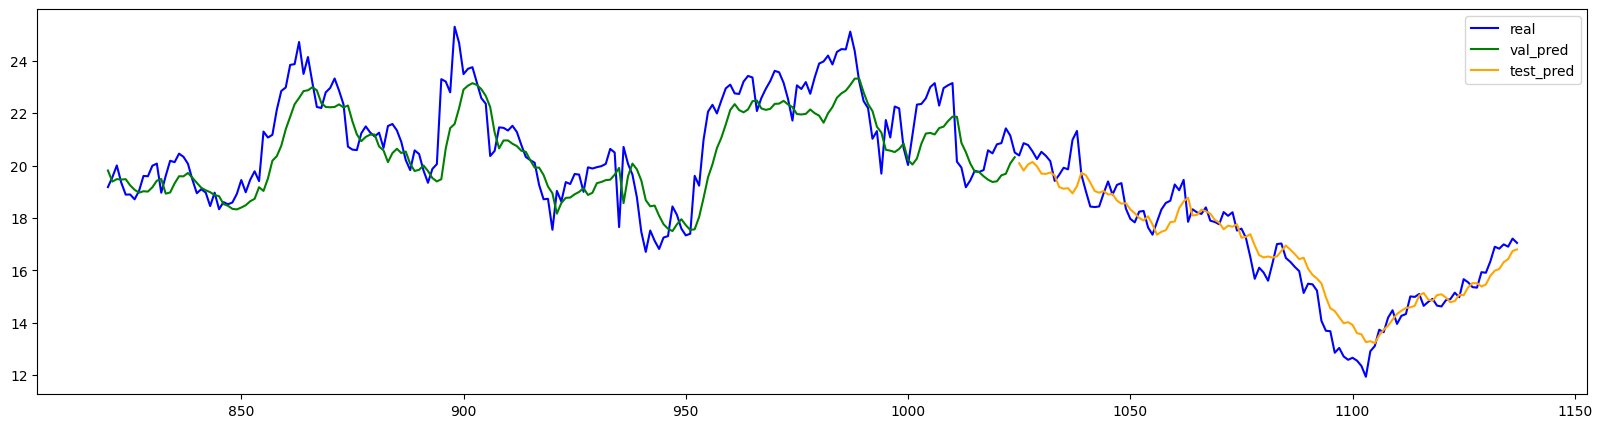

Epoch 1/1000
29/29 [==============================] - 2s 37ms/step - loss: 0.0364 - val_loss: 0.1019
Epoch 2/1000
29/29 [==============================] - 1s 35ms/step - loss: 0.0160 - val_loss: 0.1082
Epoch 3/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0126 - val_loss: 0.0762
Epoch 4/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0097 - val_loss: 0.0670
Epoch 5/1000
29/29 [==============================] - 1s 31ms/step - loss: 0.0075 - val_loss: 0.0540
Epoch 6/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0056 - val_loss: 0.0451
Epoch 7/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0043 - val_loss: 0.0370
Epoch 8/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0034 - val_loss: 0.0301
Epoch 9/1000
29/29 [==============================] - 1s 31ms/step - loss: 0.0027 - val_loss: 0.0250
Epoch 10/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0023 - val_lo

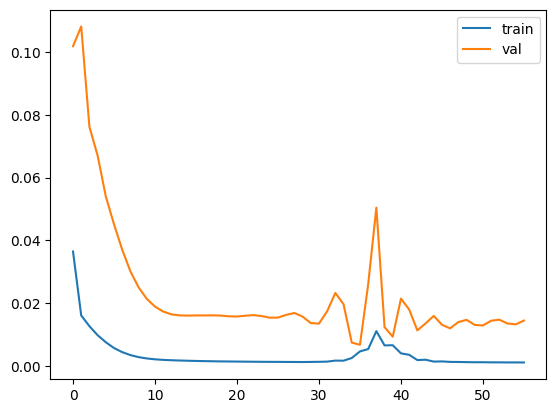

4/4 [==============================] - 0s 4ms/step
train mae: 2.4203215102085354
val mae: 1.9792900476074222
train smape: 13.247017938822706
val smape: 10.721016784813497
train forecast bias: -10.54887221936472
val forecast bias: -8.433927722440943


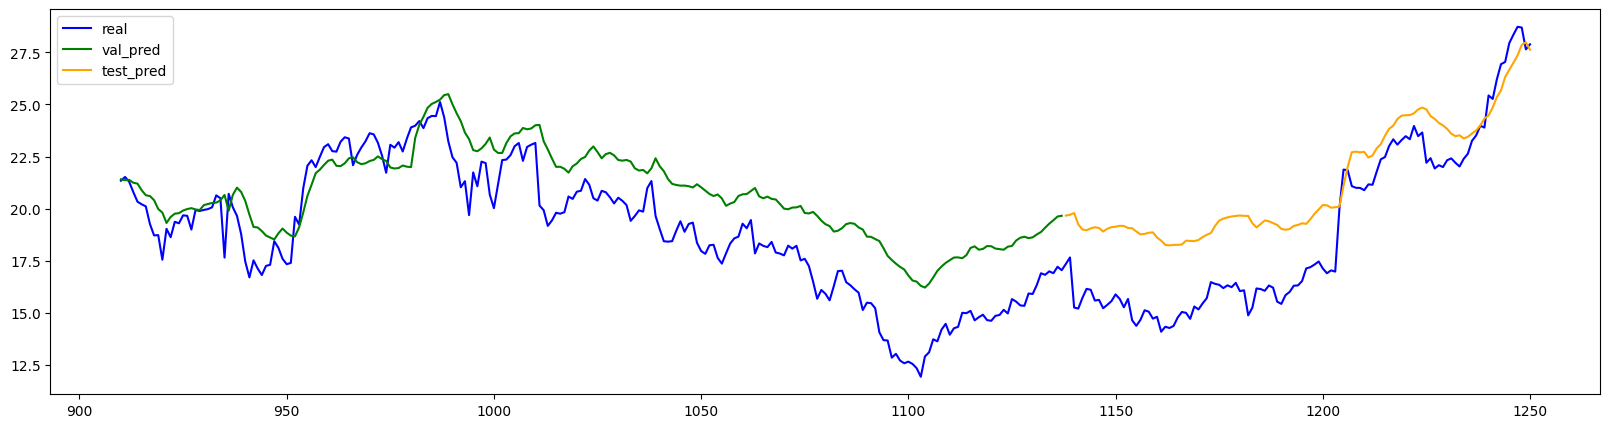

In [44]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
t_smapes=[]
v_smapes=[]
t_forecast_biases=[]
v_forecast_biases=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=mae(pred,y_test)
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=mae(val_pred,y_val)
    v_maes.append(v_mae)
    print('val mae:',v_mae)
    t_smape=smape(pred,y_test)
    t_smapes.append(t_smape)
    print('train smape:',t_smape)
    v_smape=smape(val_pred,y_val)
    v_smapes.append(v_smape)
    print('val smape:',v_smape)

    t_forecast_bias=forecast_bias(pred,y_test)
    t_forecast_biases.append(t_forecast_bias)
    print('train forecast bias:',t_forecast_bias)
    v_forecast_bias=forecast_bias(val_pred,y_val)
    v_forecast_biases.append(v_forecast_bias)
    print('val forecast bias:',v_forecast_bias)
    

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()

In [45]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirect  (None, 288)               140832    
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, 1)                 289       
                                                                 
Total params: 141121 (551.25 KB)
Trainable params: 141121 (551.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Taverage_smape=np.mean(t_smapes)

print('Average SMAPE in testing:',Taverage_smape)

Vaverage_smape=np.mean(v_smapes)

print('Average SMAPE in validation:',Vaverage_smape)


Taverage_forecast_bias=np.mean(t_forecast_biases)

print('Average forecast bias in testing:',Taverage_forecast_bias)

Vaverage_forecast_bias=np.mean(v_forecast_biases)

print('Average forecast bias in validation:',Vaverage_forecast_bias)

Average MAE in testing: 1.333662125600305
Average MAE in validation: 1.0191274182118968
Average SMAPE in testing: 7.498529630830566
Average SMAPE in validation: 5.835620321162873
Average forecast bias in testing: 1.0091163963232719
Average forecast bias in validation: 1.135850121920923
